






                                                                        Brady Gehrman
                                                                      CSE 625 Term Project
                                                                  Date Submitted: 7/25/2023












In [1]:
using Base.Threads
using Random
using LinearAlgebra
using Plots
using CUDA

In [2]:
# get the number of threads
nthreads()

4

In [3]:
struct XYPoint
    x::Float64
    y::Float64
end

function Base.hash(point::XYPoint, h::UInt = zero(UInt))
    h = hash(point.x, h)
    h = hash(point.y, h)
    return h
end

mutable struct PointObject
    label::String
    point::XYPoint
end

function Base.hash(obj::PointObject, h::UInt = zero(UInt))
    h = hash(obj.label, h)
    h = hash(obj.point, h)
    return h
end

In [4]:

function euclidean_distance_seq(point1::XYPoint, point2::XYPoint)
    return sqrt((point1.x - point2.x)^2 + (point1.y - point2.y)^2)
end

function region_query_seq(point::PointObject, data::Vector{PointObject}, eps::Float64)
    return [p for p in data if euclidean_distance_seq(point.point, p.point) <= eps]
end

function expand_cluster_seq(neighbors::Vector{PointObject}, clusters::Vector{Vector{XYPoint}}, cluster_id::Int, data::Vector{PointObject}, eps::Float64, min_samples::Int)
    setOfXYPoints = Set()
    for neighbor in neighbors
        push!(setOfXYPoints, neighbor.point)
        if neighbor.label == "undefined"  # point has not yet assigned to any cluster
            neighbor.label = "$cluster_id"
            new_neighbors = region_query_seq(neighbor, data, eps)
            if length(new_neighbors) >= min_samples
                for newNeighbor in new_neighbors
                    push!(setOfXYPoints, newNeighbor.point)
                end
            end
        end
        if neighbor.label == "noise"  # point was previously marked as noise
            neighbor.label = "$cluster_id"
        end
    end
    push!(clusters, collect(setOfXYPoints))
end

function dbscan_sequential(data::Vector{PointObject}, eps::Float64, min_samples::Int)
    clusters = Vector{Vector{XYPoint}}([])
    cluster_id = 0

    for point in data
        #if point has already been clustered, don't revisit it
        if point.label != "undefined"
            continue
        end

        neighbors = region_query_seq(point, data, eps)
        if length(neighbors) < min_samples
            point.label = "noise"  # Mark as noise/outlier
        else
            cluster_id += 1
            point.label = "$cluster_id"
            expand_cluster_seq(neighbors, clusters, cluster_id, data, eps, min_samples)
        end
    end
    #convert the clusters to a set to remove duplicate clusters
    clustersSet = Set{Set{XYPoint}}(Set.(clusters))
    return clustersSet, cluster_id
end


dbscan_sequential (generic function with 1 method)

In [5]:
# the DBSCAN algorithm works best when clusters of data are present
function generatePointsInClusters(numOfPoints::Int, numOfClusters::Int)
    #define random centroids from 0 to 10,000,000
    centroids = [XYPoint(rand() * 10000000, rand() * 10000000) for num in 1:numOfClusters]
    points_per_cluster = numOfPoints / numOfClusters
    points = PointObject[]

    for centroid in centroids
        for point in 1:points_per_cluster
            # add some random deviation around the centroid
            push!(points, PointObject("undefined", XYPoint(centroid.x + rand(-2:2), centroid.y + rand(-2:2))))
        end
    end
    return points
end

generatePointsInClusters (generic function with 1 method)

In [6]:
function resetPoints()
    for point in points
        point.label = "undefined"
    end
end

resetPoints (generic function with 1 method)

In [7]:
function plotClusters(clusters::Set{Set{XYPoint}})
    x_values = Float64[]
    y_values = Float64[]
    cluster_labels = Int[]

    for (cluster_id, cluster) in enumerate(clusters)
        for point in cluster
            push!(x_values, point.x)
            push!(y_values, point.y)
            push!(cluster_labels, cluster_id)
        end
    end
    scatter(x_values, y_values, group=cluster_labels,  legend=:topright)
    plot!(size=(1080, 720))
end

plotClusters (generic function with 1 method)

In [56]:
points = generatePointsInClusters(100000, 100)
eps = 16.0
# this value is very import for the dbscan algorithm and should equal numOfPoints / numOfClusters for our testing cases
min_samples = 50

50

In [57]:
# Run DBSCAN sequential algorithm
seqClusters, num_clusters = dbscan_sequential(points, eps, min_samples)


(Set(Set{XYPoint}[Set([XYPoint(4.550325027025097e6, 9.861976338124467e6), XYPoint(4.550326027025097e6, 9.861979338124467e6), XYPoint(4.550324027025097e6, 9.861980338124467e6), XYPoint(4.550324027025097e6, 9.861978338124467e6), XYPoint(4.550323027025097e6, 9.861980338124467e6), XYPoint(4.550322027025097e6, 9.861976338124467e6), XYPoint(4.550323027025097e6, 9.861979338124467e6), XYPoint(4.550323027025097e6, 9.861977338124467e6), XYPoint(4.550324027025097e6, 9.861979338124467e6), XYPoint(4.550324027025097e6, 9.861977338124467e6)  …  XYPoint(4.550325027025097e6, 9.861977338124467e6), XYPoint(4.550325027025097e6, 9.861979338124467e6), XYPoint(4.550322027025097e6, 9.861977338124467e6), XYPoint(4.550322027025097e6, 9.861979338124467e6), XYPoint(4.550323027025097e6, 9.861976338124467e6), XYPoint(4.550326027025097e6, 9.861980338124467e6), XYPoint(4.550326027025097e6, 9.861978338124467e6), XYPoint(4.550324027025097e6, 9.861976338124467e6), XYPoint(4.550326027025097e6, 9.861977338124467e6), XYPoi

In [58]:
length(seqClusters)

100

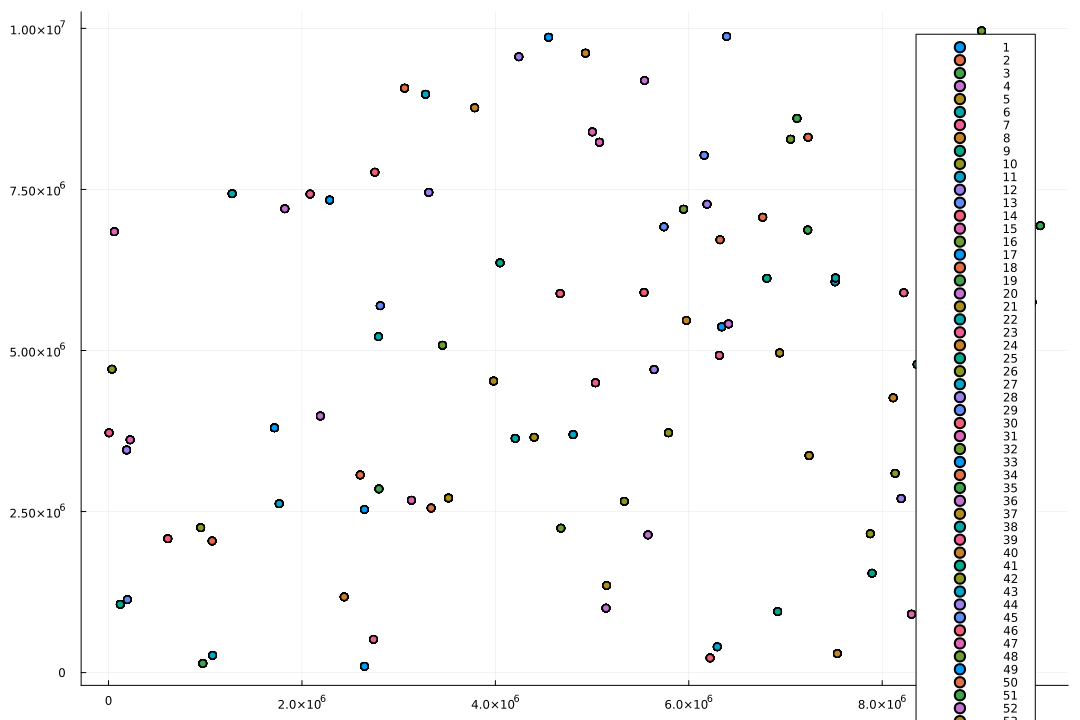

In [59]:
plotClusters(seqClusters)

2. Parallelization of dbscan using Julia threads and simd

In [60]:
#parallelization of dbscan using Julia threads and simd

function euclidean_distance_mt(point1::XYPoint, point2::XYPoint)
    return sqrt((point1.x - point2.x)^2 + (point1.y - point2.y)^2)
end

function region_query_mt(point::PointObject, data::Vector{PointObject}, eps::Float64)
    neighboringPoints = Vector{PointObject}([])
    @simd for p in data
        if euclidean_distance_mt(point.point, p.point) <= eps
            push!(neighboringPoints, p)
        end
    end

    return neighboringPoints
end

function expand_cluster_mt(neighbors::Vector{PointObject}, clusters::Vector{Vector{XYPoint}}, cluster_id::Int, data::Vector{PointObject}, eps::Float64, min_samples::Int)
    setOfXYPoints = Set()
    for neighbor in neighbors

        push!(setOfXYPoints, neighbor.point)
        
        if neighbor.label == "undefined"  # point has not yet assigned to any cluster
            neighbor.label = "clustered"
            new_neighbors = region_query_mt(neighbor, data, eps)
            if length(new_neighbors) >= min_samples
                for newNeighbor in new_neighbors
                    
                    push!(setOfXYPoints, newNeighbor.point)
                    
                end
            end
        end
        if neighbor.label == "noise"  # point was previously marked as noise
            neighbor.label = "clustered"
        end
    end
    push!(clusters, collect(setOfXYPoints))
end

function dbscan_multithreaded_with_simd(data::Vector{PointObject}, eps::Float64, min_samples::Int)
    clusters = Vector{Vector{XYPoint}}([])
    cluster_id = 0

    @threads for point in data
        #if point has already been clustered, don't revisit it
        if point.label != "undefined"
            continue
        end

        neighbors = region_query_mt(point, data, eps)
        if length(neighbors) < min_samples
            point.label = "noise"  # Mark as noise/outlier
        else
            cluster_id += 1
            point.label = "clustered"
            expand_cluster_mt(neighbors, clusters, cluster_id, data, eps, min_samples)
        end
    end
    #convert the clusters to a set to remove duplicate clusters
    clustersSet = Set{Set{XYPoint}}(Set.(clusters))
    return clustersSet, cluster_id
end


dbscan_multithreaded_with_simd (generic function with 1 method)

In [61]:
resetPoints()

In [62]:
# Run DBSCAN multithreads and simd algorithm
mtClusters, mtNumOfClusters = dbscan_multithreaded_with_simd(points, eps, min_samples)

(Set(Set{XYPoint}[Set([XYPoint(4.550325027025097e6, 9.861976338124467e6), XYPoint(4.550326027025097e6, 9.861979338124467e6), XYPoint(4.550324027025097e6, 9.861980338124467e6), XYPoint(4.550324027025097e6, 9.861978338124467e6), XYPoint(4.550323027025097e6, 9.861980338124467e6), XYPoint(4.550322027025097e6, 9.861976338124467e6), XYPoint(4.550323027025097e6, 9.861979338124467e6), XYPoint(4.550323027025097e6, 9.861977338124467e6), XYPoint(4.550324027025097e6, 9.861979338124467e6), XYPoint(4.550324027025097e6, 9.861977338124467e6)  …  XYPoint(4.550325027025097e6, 9.861977338124467e6), XYPoint(4.550325027025097e6, 9.861979338124467e6), XYPoint(4.550322027025097e6, 9.861977338124467e6), XYPoint(4.550322027025097e6, 9.861979338124467e6), XYPoint(4.550323027025097e6, 9.861976338124467e6), XYPoint(4.550326027025097e6, 9.861980338124467e6), XYPoint(4.550326027025097e6, 9.861978338124467e6), XYPoint(4.550324027025097e6, 9.861976338124467e6), XYPoint(4.550326027025097e6, 9.861977338124467e6), XYPoi

In [63]:
length(mtClusters)

100

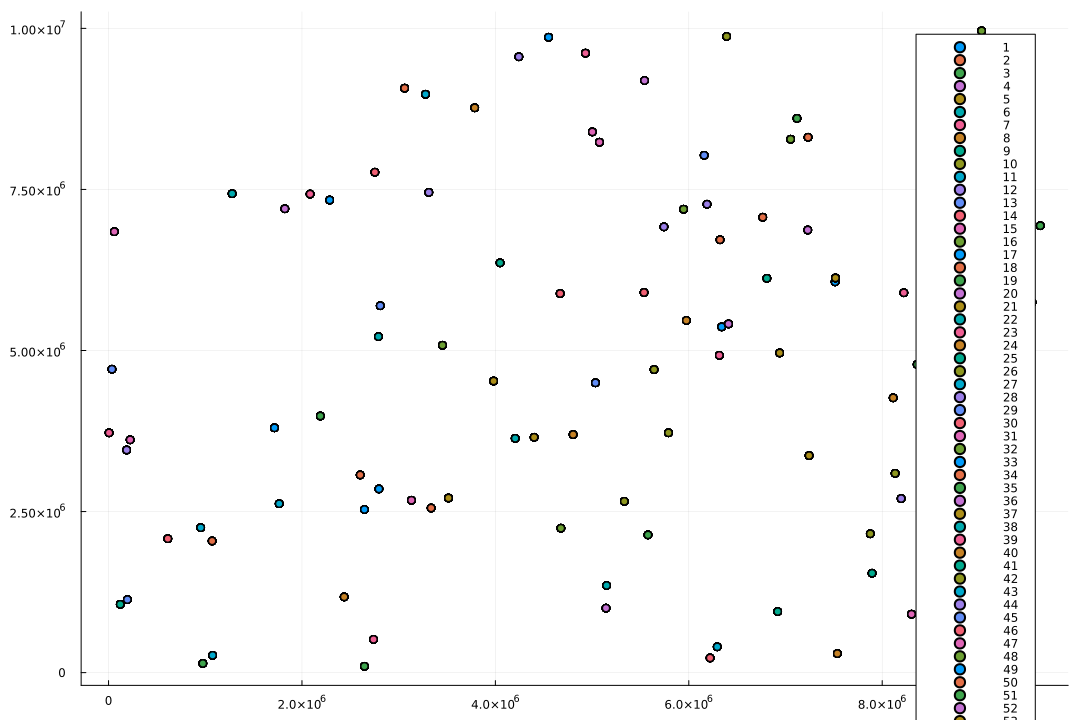

In [64]:
plotClusters(mtClusters)

In [65]:
# Make sure both algorithms have the same result
seqClusters == mtClusters 


true

3. My attempt at using GPU parallelization for the expand_cluster function using CUDA

In [53]:
# attempt at using GPU parallelization for the expand_cluster function

function euclidean_distance_cuda(point1::XYPoint, point2::XYPoint)
    return sqrt((point1.x - point2.x)^2 + (point1.y - point2.y)^2)
end

function region_query_cuda(point::PointObject, data::Vector{PointObject}, eps::Float64)
    # Try to utilize CuArray to run the region query function on the GPU without a kernel
    # data_gpu = CuArray(data)

    # neighboringPoints_gpu = filter(p -> euclidean_distance_cuda(p.point, point.point) <= eps, data_gpu)
    # neighboringPoints = CuArray{PointObject}(neighboringPoints_gpu)  # Convert back to a CuArray

    # return collect(neighboringPoints)
end

function expand_cluster_kernel(neighbors::Vector{PointObject}, clusters::Vector{Vector{XYPoint}}, cluster_id::Int, data::Vector{PointObject}, eps::Float64, min_samples::Int)
    i = (blockIdx().x-1) * blockDim().x + threadIdx().x # col index
    #iterate through each index in the neighbors array in parallel using the GPU thread indexing
    setOfXYPoints = Set()
    for neighbor in neighbors
        push!(setOfXYPoints, neighbor.point)
        if neighbor.label == "undefined"  # point has not yet assigned to any cluster
            neighbor.label = "$cluster_id"
            new_neighbors = region_query_cuda(neighbor, data, eps)
            if length(new_neighbors) >= min_samples
                for newNeighbor in new_neighbors
                    push!(setOfXYPoints, newNeighbor.point)
                end
            end
        end
        if neighbor.label == "noise"  # point was previously marked as noise
            neighbor.label = "$cluster_id"
        end
    end
    push!(clusters, collect(setOfXYPoints))
    return 
end

function expand_cluster_cuda(neighbors::CuVector{PointObject}, clusters::Vector{Vector{XYPoint}}, cluster_id::Int, data::CuVector{PointObject}, eps::Float64, min_samples::Int)
    setOfXYPoints = Set()
    for neighbor in neighbors
        push!(setOfXYPoints, neighbor.point)
        if neighbor.label == "undefined"  # point has not yet assigned to any cluster
            neighbor.label = "$cluster_id"
            new_neighbors = region_query_cuda(neighbor, data, eps)
            if length(new_neighbors) >= min_samples
                for newNeighbor in new_neighbors
                    push!(setOfXYPoints, newNeighbor.point)
                end
            end
        end
        if neighbor.label == "noise"  # point was previously marked as noise
            neighbor.label = "$cluster_id"
        end
    end
    push!(clusters, collect(setOfXYPoints))

    # try to use a CUDA kernal to 
    # setOfXYPoints = CuSet{XYPoint}()

    # # Convert the neighbors to a GPU array
    # neighbors_cuda = CuArray(neighbors)

    # # Determine the number of threads and blocks for launching the kernel
    # num_threads = length(neighbors) #num_threads is equal to num of elements inside of the neighbors array
    # num_blocks = 1

    # # Launch the custom CUDA kernel
    # CUDA.@sync begin 
    # @cuda threads=num_threads blocks=num_blocks expand_cluster_kernel(neighbors_cuda, clusters, cluster_id, data, eps, min_samples)
    # end

end

function dbscan_cuda(data::Vector{PointObject}, eps::Float64, min_samples::Int)
    clusters = Vector{Vector{XYPoint}}([])
    cluster_id = 0

    for point in data
        #if point has already been clustered, don't revisit it
        if point.label != "undefined"
            continue
        end

        neighbors = region_query_cuda(point, data, eps)
        if length(neighbors) < min_samples
            point.label = "noise"  # Mark as noise/outlier
        else
            cluster_id += 1
            point.label = "$cluster_id"
            expand_cluster_cuda(neighbors, clusters, cluster_id, data, eps, min_samples)
        end
    end
    #convert the clusters to a set to remove duplicate clusters
    clustersSet = Set{Set{XYPoint}}(Set.(clusters))
    return clustersSet, cluster_id
end

dbscan_cuda (generic function with 1 method)

In [54]:
resetPoints()

In [55]:
# gpuClusters, num = dbscan_cuda(points, eps, min_samples)

Timing Testing Area:

In [66]:
points = generatePointsInClusters(100, 10)
eps = 16.0
min_samples = 10

10

In [78]:
@time dbscan_sequential(points, eps, min_samples)

  0.000555 seconds (12.71 k allocations: 446.719 KiB)


(Set(Set{XYPoint}[Set([XYPoint(2.2320120387225207e6, 9.737693730614083e6), XYPoint(2.2320110387225207e6, 9.737693730614083e6), XYPoint(2.2320100387225207e6, 9.737693730614083e6), XYPoint(2.2320100387225207e6, 9.737691730614083e6), XYPoint(2.2320120387225207e6, 9.737695730614083e6), XYPoint(2.2320110387225207e6, 9.737694730614083e6), XYPoint(2.2320080387225207e6, 9.737691730614083e6), XYPoint(2.2320080387225207e6, 9.737695730614083e6), XYPoint(2.2320080387225207e6, 9.737694730614083e6), XYPoint(2.2320120387225207e6, 9.737692730614083e6)]), Set([XYPoint(958313.8556689324, 6.020526922347194e6), XYPoint(958313.8556689324, 6.020524922347194e6), XYPoint(958314.8556689324, 6.020526922347194e6), XYPoint(958316.8556689324, 6.020528922347194e6), XYPoint(958315.8556689324, 6.020526922347194e6)]), Set([XYPoint(2.7695019649562617e6, 1.1482295555109135e6), XYPoint(2.7695019649562617e6, 1.1482275555109135e6), XYPoint(2.7695019649562617e6, 1.1482265555109135e6), XYPoint(2.7695039649562617e6, 1.1482255

In [67]:
resetPoints()
@time dbscan_multithreaded_with_simd(points, eps, min_samples)

  0.000239 seconds (1.54 k allocations: 97.359 KiB)


(Set(Set{XYPoint}[Set([XYPoint(7.512970003817694e6, 6.961265409150617e6), XYPoint(7.512968003817694e6, 6.961265409150617e6), XYPoint(7.512970003817694e6, 6.961263409150617e6), XYPoint(7.512968003817694e6, 6.961262409150617e6), XYPoint(7.512969003817694e6, 6.961266409150617e6), XYPoint(7.512970003817694e6, 6.961264409150617e6), XYPoint(7.512968003817694e6, 6.961264409150617e6), XYPoint(7.512969003817694e6, 6.961263409150617e6), XYPoint(7.512969003817694e6, 6.961262409150617e6), XYPoint(7.512971003817694e6, 6.961264409150617e6)]), Set([XYPoint(4.266162275540594e6, 8.25212770868468e6), XYPoint(4.266162275540594e6, 8.25212870868468e6), XYPoint(4.266165275540594e6, 8.25212770868468e6), XYPoint(4.266165275540594e6, 8.25212870868468e6), XYPoint(4.266164275540594e6, 8.25212870868468e6), XYPoint(4.266165275540594e6, 8.25213170868468e6), XYPoint(4.266162275540594e6, 8.25212970868468e6), XYPoint(4.266162275540594e6, 8.25213070868468e6), XYPoint(4.266166275540594e6, 8.25212870868468e6)]), Set([XYP

In [68]:
points = generatePointsInClusters(1000, 10)
eps = 16.0
min_samples = 100

100

In [72]:
@time dbscan_sequential(points, eps, min_samples)

  0.092882 seconds (1.21 M allocations: 38.654 MiB, 48.76% gc time)


(Set(Set{XYPoint}[Set([XYPoint(9.00225275189998e6, 4.2706290508067245e6), XYPoint(9.00225375189998e6, 4.2706290508067245e6), XYPoint(9.00225075189998e6, 4.2706280508067245e6), XYPoint(9.00225475189998e6, 4.2706300508067245e6), XYPoint(9.00225275189998e6, 4.2706300508067245e6), XYPoint(9.00225375189998e6, 4.2706300508067245e6), XYPoint(9.00225475189998e6, 4.2706270508067245e6), XYPoint(9.00225475189998e6, 4.2706310508067245e6), XYPoint(9.00225275189998e6, 4.2706310508067245e6), XYPoint(9.00225275189998e6, 4.2706270508067245e6)  …  XYPoint(9.00225275189998e6, 4.2706280508067245e6), XYPoint(9.00225375189998e6, 4.2706280508067245e6), XYPoint(9.00225075189998e6, 4.2706290508067245e6), XYPoint(9.00225175189998e6, 4.2706310508067245e6), XYPoint(9.00225175189998e6, 4.2706270508067245e6), XYPoint(9.00225075189998e6, 4.2706300508067245e6), XYPoint(9.00225075189998e6, 4.2706270508067245e6), XYPoint(9.00225075189998e6, 4.2706310508067245e6), XYPoint(9.00225175189998e6, 4.2706280508067245e6), XYPoi

In [69]:
resetPoints()
@time dbscan_multithreaded_with_simd(points, eps, min_samples)

  0.007203 seconds (105.31 k allocations: 5.003 MiB)


(Set(Set{XYPoint}[Set([XYPoint(6.232260964942647e6, 7.321122379612011e6), XYPoint(6.232259964942647e6, 7.321120379612011e6), XYPoint(6.232259964942647e6, 7.321121379612011e6), XYPoint(6.232256964942647e6, 7.321119379612011e6), XYPoint(6.232257964942647e6, 7.321118379612011e6), XYPoint(6.232260964942647e6, 7.321120379612011e6), XYPoint(6.232260964942647e6, 7.321121379612011e6), XYPoint(6.232259964942647e6, 7.321119379612011e6), XYPoint(6.232260964942647e6, 7.321119379612011e6), XYPoint(6.232258964942647e6, 7.321122379612011e6)  …  XYPoint(6.232257964942647e6, 7.321120379612011e6), XYPoint(6.232257964942647e6, 7.321121379612011e6), XYPoint(6.232260964942647e6, 7.321118379612011e6), XYPoint(6.232258964942647e6, 7.321119379612011e6), XYPoint(6.232256964942647e6, 7.321122379612011e6), XYPoint(6.232257964942647e6, 7.321119379612011e6), XYPoint(6.232259964942647e6, 7.321122379612011e6), XYPoint(6.232256964942647e6, 7.321120379612011e6), XYPoint(6.232256964942647e6, 7.321121379612011e6), XYPoi

In [70]:
points = generatePointsInClusters(10000, 100)
eps = 16.0
min_samples = 100

100

In [63]:
@time dbscan_sequential(points, eps, min_samples)

  2.900130 seconds (102.07 M allocations: 3.060 GiB, 20.13% gc time)


(Set(Set{XYPoint}[Set([XYPoint(9.229219151288945e6, 2.0392042641163755e6), XYPoint(9.229220151288945e6, 2.0392022641163755e6), XYPoint(9.229221151288945e6, 2.0392032641163755e6), XYPoint(9.229217151288945e6, 2.0392022641163755e6), XYPoint(9.229221151288945e6, 2.0392012641163755e6), XYPoint(9.229218151288945e6, 2.0392022641163755e6), XYPoint(9.229221151288945e6, 2.0392002641163755e6), XYPoint(9.229219151288945e6, 2.0392022641163755e6), XYPoint(9.229220151288945e6, 2.0392032641163755e6), XYPoint(9.229221151288945e6, 2.0392042641163755e6)  …  XYPoint(9.229220151288945e6, 2.0392042641163755e6), XYPoint(9.229218151288945e6, 2.0392012641163755e6), XYPoint(9.229217151288945e6, 2.0392002641163755e6), XYPoint(9.229219151288945e6, 2.0392032641163755e6), XYPoint(9.229218151288945e6, 2.0392002641163755e6), XYPoint(9.229219151288945e6, 2.0392012641163755e6), XYPoint(9.229221151288945e6, 2.0392022641163755e6), XYPoint(9.229217151288945e6, 2.0392042641163755e6), XYPoint(9.229218151288945e6, 2.0392042

In [71]:
resetPoints()
@time dbscan_multithreaded_with_simd(points, eps, min_samples)

  0.180050 seconds (1.05 M allocations: 50.002 MiB, 35.24% gc time)


(Set(Set{XYPoint}[Set([XYPoint(7.365552405890325e6, 6.516105750642077e6), XYPoint(7.365553405890325e6, 6.516105750642077e6), XYPoint(7.365552405890325e6, 6.516103750642077e6), XYPoint(7.365553405890325e6, 6.516103750642077e6), XYPoint(7.365549405890325e6, 6.516101750642077e6), XYPoint(7.365549405890325e6, 6.516104750642077e6), XYPoint(7.365551405890325e6, 6.516105750642077e6), XYPoint(7.365550405890325e6, 6.516101750642077e6), XYPoint(7.365550405890325e6, 6.516104750642077e6), XYPoint(7.365551405890325e6, 6.516103750642077e6)  …  XYPoint(7.365550405890325e6, 6.516105750642077e6), XYPoint(7.365551405890325e6, 6.516102750642077e6), XYPoint(7.365552405890325e6, 6.516104750642077e6), XYPoint(7.365552405890325e6, 6.516101750642077e6), XYPoint(7.365553405890325e6, 6.516101750642077e6), XYPoint(7.365553405890325e6, 6.516104750642077e6), XYPoint(7.365549405890325e6, 6.516102750642077e6), XYPoint(7.365550405890325e6, 6.516102750642077e6), XYPoint(7.365551405890325e6, 6.516101750642077e6), XYPoi

In [76]:
points = generatePointsInClusters(100000, 1000)
eps = 16.0
min_samples = 100

100

In [66]:
@time dbscan_sequential(points, eps, min_samples)

278.241428 seconds (10.02 G allocations: 298.818 GiB, 20.26% gc time)


(Set(Set{XYPoint}[Set([XYPoint(1.2844048455578566e6, 6.288139365376825e6), XYPoint(1.2844048455578566e6, 6.288136365376825e6), XYPoint(1.2844048455578566e6, 6.288138365376825e6), XYPoint(1.2844038455578566e6, 6.288139365376825e6), XYPoint(1.2844038455578566e6, 6.288136365376825e6), XYPoint(1.2844068455578566e6, 6.288139365376825e6), XYPoint(1.2844048455578566e6, 6.288137365376825e6), XYPoint(1.2844038455578566e6, 6.288138365376825e6), XYPoint(1.2844068455578566e6, 6.288136365376825e6), XYPoint(1.2844048455578566e6, 6.288140365376825e6)  …  XYPoint(1.2844058455578566e6, 6.288136365376825e6), XYPoint(1.2844068455578566e6, 6.288140365376825e6), XYPoint(1.2844058455578566e6, 6.288138365376825e6), XYPoint(1.2844058455578566e6, 6.288137365376825e6), XYPoint(1.2844078455578566e6, 6.288139365376825e6), XYPoint(1.2844058455578566e6, 6.288140365376825e6), XYPoint(1.2844078455578566e6, 6.288136365376825e6), XYPoint(1.2844078455578566e6, 6.288138365376825e6), XYPoint(1.2844078455578566e6, 6.288137

In [ ]:
resetPoints()
@time dbscan_multithreaded_with_simd(points, eps, min_samples)

In [81]:
points = generatePointsInClusters(200000, 1000)
eps = 16.0
min_samples = 200

200

In [69]:
@time dbscan_sequential(points, eps, min_samples)

1244.577678 seconds (40.08 G allocations: 1.168 TiB, 21.33% gc time)


(Set(Set{XYPoint}[Set([XYPoint(1.6029677496496309e6, 6.958400509033474e6), XYPoint(1.6029657496496309e6, 6.958400509033474e6), XYPoint(1.6029687496496309e6, 6.958404509033474e6), XYPoint(1.6029697496496309e6, 6.958404509033474e6), XYPoint(1.6029667496496309e6, 6.958404509033474e6), XYPoint(1.6029687496496309e6, 6.958403509033474e6), XYPoint(1.6029697496496309e6, 6.958401509033474e6), XYPoint(1.6029697496496309e6, 6.958402509033474e6), XYPoint(1.6029687496496309e6, 6.958402509033474e6), XYPoint(1.6029697496496309e6, 6.958403509033474e6)  …  XYPoint(1.6029657496496309e6, 6.958404509033474e6), XYPoint(1.6029677496496309e6, 6.958401509033474e6), XYPoint(1.6029657496496309e6, 6.958401509033474e6), XYPoint(1.6029677496496309e6, 6.958403509033474e6), XYPoint(1.6029657496496309e6, 6.958402509033474e6), XYPoint(1.6029677496496309e6, 6.958402509033474e6), XYPoint(1.6029657496496309e6, 6.958403509033474e6), XYPoint(1.6029687496496309e6, 6.958400509033474e6), XYPoint(1.6029697496496309e6, 6.958400

In [82]:
resetPoints()
@time dbscan_multithreaded_with_simd(points, eps, min_samples)

 78.690354 seconds (41.26 M allocations: 2.644 GiB, 0.74% gc time)


(Set(Set{XYPoint}[Set([XYPoint(1.492062597606859e6, 5.289078535397827e6), XYPoint(1.492061597606859e6, 5.289079535397827e6), XYPoint(1.492062597606859e6, 5.289081535397827e6), XYPoint(1.492060597606859e6, 5.289081535397827e6), XYPoint(1.492059597606859e6, 5.289079535397827e6), XYPoint(1.492062597606859e6, 5.289080535397827e6), XYPoint(1.492060597606859e6, 5.289080535397827e6), XYPoint(1.492062597606859e6, 5.289077535397827e6), XYPoint(1.492060597606859e6, 5.289077535397827e6), XYPoint(1.492058597606859e6, 5.289078535397827e6)  …  XYPoint(1.492061597606859e6, 5.289078535397827e6), XYPoint(1.492059597606859e6, 5.289078535397827e6), XYPoint(1.492061597606859e6, 5.289081535397827e6), XYPoint(1.492058597606859e6, 5.289079535397827e6), XYPoint(1.492059597606859e6, 5.289081535397827e6), XYPoint(1.492061597606859e6, 5.289080535397827e6), XYPoint(1.492061597606859e6, 5.289077535397827e6), XYPoint(1.492059597606859e6, 5.289080535397827e6), XYPoint(1.492059597606859e6, 5.289077535397827e6), XYPoi